<a href="https://colab.research.google.com/github/theindianwriter/CS6910-assignment_2/blob/main/DL_assignment_2_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librabries imported

In [ ]:
import numpy as np #for linear algebra operations
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image #for preprocessing the images
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gc

#wandb Login

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 2.1MB 19.9MB/s 
     |████████████████████████████████| 163kB 57.3MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 133kB 57.2MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#Dataset loading from the drive and Resizing

In [ ]:
#enabling gpu 
device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/My Drive/nature_12K.zip" -d "/content/drive/My Drive/"

In [ ]:
training_folder_path = "/content/drive/MyDrive/inaturalist_12K/train"
test_folder_path = "/content/drive/MyDrive/inaturalist_12K/test"
#validation_folder_path = "/content/drive/MyDrive/inaturalist_12K/validation"

In [ ]:
#list down all the classes present in the dataset
classes = sorted([folder_name  for folder_name in os.listdir(training_folder_path) if not folder_name.startswith('.')])
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [ ]:
# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    #creating a thumbnail of the image of the given size preserving the aspect ratio
    src_image.thumbnail(size,Image.ANTIALIAS)
    #creating a background image 
    new_image = Image.new("RGB", size, bg_color)
    #pasting the src image into it 
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
    return new_image

In [ ]:
new_training_folder_path = "/content/drive/MyDrive/Natural_Dataset256/train"
new_test_folder_path = '/content/drive/MyDrive/Natural_Dataset256/test'
#new_validation_folder_path = './Natural_Dataset256/validation'

In [ ]:
def Resize_all(old_path,new_path,size=(256,256)):

    image_size = size

    # if os.path.exists(new_path):
    #     shutil.rmtree(new_path)
    print("the new path is ",new_path)
    for root,folders,_ in os.walk(old_path):
        for folder in folders:
            print("resizing the images and saving for the folder ",folder)
            new_folder = os.path.join(new_path,folder)

            if not os.path.exists(new_folder):
                os.makedirs(new_folder)

            # if os.path.exists(os.path.join(root,folder)):

        
            file_names = os.listdir(os.path.join(root,folder))

            for file_name in file_names:
                if file_name.startswith('.'):
                    continue
                
                file_path = os.path.join(root,folder,file_name)
                image = Image.open(file_path)
                resized_image = resize_image(image,image_size,"white")
                save_as = os.path.join(new_folder,file_name)
                resized_image.save(save_as)

    print("resizing and saving done")


In [ ]:
Resize_all(training_folder_path,new_training_folder_path)
#Resize_all(validation_folder_path,new_validation_folder_path)

the new path is  /content/drive/MyDrive/Natural_Dataset256/train
resizing the images and saving for the folder  Reptilia
resizing the images and saving for the folder  Mammalia
resizing the images and saving for the folder  Arachnida
resizing the images and saving for the folder  Plantae
resizing the images and saving for the folder  Aves
resizing the images and saving for the folder  Amphibia
resizing the images and saving for the folder  Insecta
resizing the images and saving for the folder  Animalia
resizing the images and saving for the folder  Mollusca
resizing the images and saving for the folder  Fungi
resizing and saving done


In [ ]:
Resize_all(test_folder_path,new_test_folder_path)

the new path is  /content/drive/MyDrive/Natural_Dataset256/test
resizing the images and saving for the folder  Amphibia
resizing the images and saving for the folder  Aves
resizing the images and saving for the folder  Plantae
resizing the images and saving for the folder  Insecta
resizing the images and saving for the folder  Reptilia
resizing the images and saving for the folder  Mammalia
resizing the images and saving for the folder  Mollusca
resizing the images and saving for the folder  Fungi
resizing the images and saving for the folder  Animalia
resizing the images and saving for the folder  Arachnida
resizing and saving done


#After resizing, loading the dataset into a train loader, test loader and val loader in batches


In [ ]:
mean = [0.5,0.5,0.5]
std = [0.5,0.5,0.5]

def load_dataset(dataset_path,data_augmentation = False,batch_size = 50,is_test = False):
    if data_augmentation:
        transformation = transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.3),
            transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        transformation = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,std = std)                               
        ])

    full_dataset = torchvision.datasets.ImageFolder(
        root=dataset_path,
        transform=transformation
    )
    if is_test:
        test_loader = torch.utils.data.DataLoader(
            full_dataset,
            batch_size=batch_size,
            num_workers=0,
            shuffle=False
        ) 
        return test_loader

    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )
    return train_loader,val_loader

In [ ]:
print(device)

cuda


# The convolutional model

In [ ]:
class Network(nn.Module):

    def __init__(self,num_of_classes,filters,filter_size,activation_fn,stride_len = 1,batch_norm = True,padding_len = 1,max_pool_kernel_size = 2,max_pool_stride_len = 2,dropdout_ratio = 0.0,dense_neuron_size = 20000,img_size = (256,256)):
        super(Network,self).__init__()

        self.activation_fn = activation_fn
        self.batch_norm = batch_norm

        Out_dim_H = img_size[0]
        Out_dim_W = img_size[1]

        for F in filter_size:
            Out_dim_H =  int(((Out_dim_H - F + 2*padding_len)/stride_len)) + 1
            Out_dim_W =  int(((Out_dim_W - F + 2*padding_len)/stride_len)) + 1
            Out_dim_H =  int(((Out_dim_H - max_pool_kernel_size)/max_pool_stride_len))+ 1
            Out_dim_W =  int(((Out_dim_W - max_pool_kernel_size)/max_pool_stride_len)) + 1


        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = filters[0],kernel_size = filter_size[0],stride = stride_len,padding = padding_len)
        self.conv2 = nn.Conv2d(in_channels = filters[0],out_channels = filters[1],kernel_size = filter_size[1],stride = stride_len,padding = padding_len)
        self.conv3 = nn.Conv2d(in_channels = filters[1],out_channels = filters[2],kernel_size = filter_size[2],stride = stride_len,padding = padding_len)
        self.conv4 = nn.Conv2d(in_channels = filters[2],out_channels = filters[3],kernel_size = filter_size[3],stride = stride_len,padding = padding_len)
        self.conv5 = nn.Conv2d(in_channels = filters[3],out_channels = filters[4],kernel_size = filter_size[4],stride = stride_len,padding = padding_len)

        self.pool = nn.MaxPool2d(kernel_size=max_pool_kernel_size,stride = max_pool_stride_len)

        self.drop = nn.Dropout2d(p=dropdout_ratio)
        
        if self.batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(num_features=filters[0], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.batch_norm2 = nn.BatchNorm2d(num_features=filters[1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.batch_norm3 = nn.BatchNorm2d(num_features=filters[2], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.batch_norm4 = nn.BatchNorm2d(num_features=filters[3], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.batch_norm5 = nn.BatchNorm2d(num_features=filters[4], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

        self.post_conv_output_len = Out_dim_H*Out_dim_W*filters[4]
        #fully connected layer
        self.fc1 = nn.Linear(in_features = Out_dim_H*Out_dim_W*filters[4],out_features = dense_neuron_size)
        self.fc2 = nn.Linear(in_features = dense_neuron_size,out_features = num_of_classes)



    def perform_activation(self,fn,x):
        if fn == 'relu':
            return F.relu(x)
        elif fn == 'elu':
            return F.elu(x)
        elif fn == 'leaky_relu':
            return F.leaky_relu(x)
        elif fn == 'tanh':
            return torch.tanh(x)
        elif fn == 'sigmoid':
            return F.sigmoid(x)

    def forward(self,x):
        if self.batch_norm:
            x = self.batch_norm1(self.conv1(x))
        else:
            x = self.conv1(x)

        x = self.pool(self.perform_activation(self.activation_fn[0],x))

        if self.batch_norm:
            x = self.batch_norm2(self.conv2(x))
        else:
            x = self.conv2(x)
    
        x = self.pool(self.perform_activation(self.activation_fn[1],x))

        if self.batch_norm:
            x = self.batch_norm3(self.conv3(x))
        else:
            x = self.conv3(x)


        x = self.pool(self.perform_activation(self.activation_fn[2],x))

        if self.batch_norm:
            x = self.batch_norm4(self.conv4(x))
        else:
            x = self.conv4(x)

        x = self.pool(self.perform_activation(self.activation_fn[3],x))
    
        if self.batch_norm:
            x = self.batch_norm5(self.conv5(x))
        else:
            x = self.conv5(x)

        x = self.pool(self.perform_activation(self.activation_fn[4],x))

        x = F.dropout(self.drop(x), training=self.training)

        x = x.view(-1, self.post_conv_output_len)

        x = F.relu(self.fc1(x))

        x = F.dropout(self.drop(x), training=self.training)

        x = self.fc2(x)
            
        return torch.log_softmax(x, dim=1)

In [ ]:
def train(model,train_loader,optimizer,epoch,device):

    model.train()
    training_loss = 0
    batch_id = 0
    print("----------------------IN EPOCH {}--------------------------------".format(epoch))
    for data,target in train_loader:
        batch_id += 1
        data,target = data.to(device),target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = loss_criteria(output,target)
        training_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("avg training loss is {:.6f}".format(training_loss/batch_id))
    return training_loss


In [ ]:
def test(model,test_loader,device):
    model.eval()
    test_loss = 0
    correct = 0
    batch_id = 0
    with torch.no_grad():
        for data,target in test_loader:
            batch_id += 1
            data,target = data.to(device),target.to(device)
            print(target)
            output = model(data)
            loss = loss_criteria(output,target)
            test_loss += loss.item()
            _,predicted = torch.max(output.data,1)
            correct += torch.sum(target==predicted).item()
    accuracy = (100*correct/ len(test_loader.dataset))
    print("avg val loss is {:.6f} and accuracy is {:.2f}%".format(test_loss/batch_id,accuracy))
    return test_loss,accuracy

    


#Training the model on custom hyper parameters

In [ ]:
model = Network(num_of_classes=10,filters = [32,64,128,256,512],filter_size = [5,5,5,5,5],activation_fn=['tanh','tanh','tanh','tanh','tanh'],dropdout_ratio = 0.5,dense_neuron_size = 256,batch_norm = True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_criteria = nn.CrossEntropyLoss()
train_loader,val_loader = load_dataset(new_training_folder_path,False,200)
epochs = 20
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer,epoch,device)
        test_loss = test(model, val_loader,device)
        torch.cuda.empty_cache()
        

Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.255514
avg val loss is 2.092842 and accuracy is 27.40%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.157679
avg val loss is 2.034590 and accuracy is 28.30%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.126044
avg val loss is 2.000279 and accuracy is 30.70%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.098106
avg val loss is 1.988044 and accuracy is 30.80%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.074774
avg val loss is 1.967815 and accuracy is 31.30%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.055943
avg val loss is 1.972563 and accuracy is 29.70%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.039542
avg val loss is 1.939554 and a

#Saving and loading the best model

In [ ]:
torch.save(model,"/content/drive/MyDrive/Natural_Dataset256/Best_model/1")

In [ ]:
#the network needs to run before running it.
#make sure to enable the gpu
model = torch.load("/content/drive/MyDrive/Natural_Dataset256/Best_model/1")

#Wandb sweep configuration

In [ ]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'lr': {
            'values': [0.0001, 0.0002,0.0004]
        },
        'activation_fn': {
            'values': ['relu', 'tanh','leaky_relu']
        },
        'num_of_filters': {
            'values' : [32,64,128,256]
        },
        'filter_size' : {
            'values' : [3,5,7]
        },
        'filter_organization':{
            'values': [2,1]
        },
        'batch_size':{
            'values': [100,200]
        },
        'dropdout_ratio': {
            'values': [0.2,0.3,0.4,0.5]
        },
        'dense_neuron_size':{
            'values' : [256,128,64]
        },
        'data_augmentation':{
            'values': [True,False]
        },
        'epochs':{
            'values' : [10,5,15]
        },
        'batch_norm':{
            'values' : [True,False]
        },


    }
}

In [ ]:
def experiment():
    defaults = dict(
        num_of_filter = 32,
        filter_size = 5,
        filter_organization = 2,
        activation_fn='tanh',
        dropout_ratio = 0.3,
        dense_neuron_size = 64,
        lr = 0.0001,
        batch_size = 8,
        epochs = 10,
        data_augmentation = True,
        batch_norm = True
    )

    wandb.init(project="cs6910-assignment2-part_a",config = defaults)
    config = wandb.config

    filters = []
    filter_size = []
    activation_fn = []  
    rate = 1
    for i in range(5):
        activation_fn.append(config.activation_fn)
        filter_size.append(config.filter_size)
        filters.append(config.num_of_filter*rate)
        rate *= config.filter_organization

    model = Network(num_of_classes=10,filters = filters,filter_size = filter_size,activation_fn=activation_fn,dropdout_ratio = config.dropout_ratio,dense_neuron_size = config.dense_neuron_size,batch_norm = config.batch_norm).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)

    loss_criteria = nn.CrossEntropyLoss()
    train_loader,val_loader = load_dataset(new_training_folder_path,config.data_augmentation,config.batch_size)
    epochs = config.epochs
    print('Training on', device)
    for epoch in range(1, epochs + 1):
        gc.collect()
        torch.cuda.empty_cache()
        train_loss = train(model, train_loader, optimizer,epoch,device)
        val_loss,accuracy = test(model, val_loader,device)
        wandb.log({"epoch": epoch,"accuracy" : accuracy,"training loss":train_loss,"validation loss": val_loss })
        
    del model

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="theindianwriter", project="cs6910-assignment2-part_a")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: fm8gabmx
Sweep URL: https://wandb.ai/theindianwriter/cs6910-assignment2-part_a/sweeps/fm8gabmx


In [ ]:
wandb.agent(sweep_id, experiment)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: kmdlu97u with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: 1
wandb: 	filter_size: 5
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.352233
avg val loss is 2.280871 and accuracy is 19.70%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.288860
avg val loss is 2.255837 and accuracy is 21.50%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.265626
avg val loss is 2.224513 and accuracy is 24.50%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.254328
avg val loss is 2.204476 and accuracy is 25.40%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.239879
avg val loss is 2.181257 and accuracy is 24.40%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.225736
avg val loss is 2.162044 and accuracy is 26.90%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.208331
avg val loss is 2.148858 and a

epoch,10
accuracy,28.5
training loss,197.1502
validation loss,21.12257
_runtime,849
_timestamp,1618307762
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
accuracy,▁▂▄▅▄▆█▆▇▇
training loss,█▅▄▄▃▃▂▂▁▁
validation loss,█▇▆▅▄▃▃▂▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: l10mf64o with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.2
wandb: 	epochs: 10
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 3
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run l10mf64o errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: u4vytn6y with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 10
wandb: 	filter_organization: 2
wandb: 	filter_size: 3
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.291244
avg val loss is 2.251093 and accuracy is 23.30%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.239224
avg val loss is 2.186530 and accuracy is 25.40%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.198320
avg val loss is 2.144884 and accuracy is 28.70%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.172736
avg val loss is 2.119184 and accuracy is 29.70%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.132574
avg val loss is 2.070397 and accuracy is 33.80%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.098507
avg val loss is 2.031222 and accuracy is 36.20%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.067442
avg val loss is 1.991646 and a

epoch,10
accuracy,39.2
training loss,180.00622
validation loss,19.3728
_runtime,760
_timestamp,1618308535
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
accuracy,▁▂▃▄▆▇▇▇██
training loss,█▇▆▅▄▃▃▂▂▁
validation loss,█▇▆▅▄▃▂▂▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 6qzxukxv with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 5
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run 6qzxukxv errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: 9xfpqtlx with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: 1
wandb: 	filter_size: 7
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.291251
avg val loss is 2.256816 and accuracy is 20.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.263626
avg val loss is 2.216697 and accuracy is 22.70%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.236908
avg val loss is 2.212519 and accuracy is 22.20%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.239038
avg val loss is 2.202577 and accuracy is 22.30%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.222248
avg val loss is 2.185672 and accuracy is 23.50%


epoch,5
accuracy,23.5
training loss,200.00228
validation loss,21.85672
_runtime,474
_timestamp,1618309022
_step,4


epoch,▁▃▅▆█
accuracy,▁▆▅▅█
training loss,█▅▂▃▁
validation loss,█▄▄▃▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ooqpvvo with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: 2
wandb: 	filter_size: 3
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.190673
avg val loss is 2.109154 and accuracy is 29.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.065026
avg val loss is 2.060793 and accuracy is 32.30%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.012148
avg val loss is 2.003528 and accuracy is 35.80%
----------------------IN EPOCH 4--------------------------------
avg training loss is 1.968356
avg val loss is 1.979537 and accuracy is 36.20%
----------------------IN EPOCH 5--------------------------------
avg training loss is 1.939788
avg val loss is 1.955355 and accuracy is 36.60%


epoch,5
accuracy,36.6
training loss,174.58092
validation loss,19.55355
_runtime,412
_timestamp,1618309459
_step,4


epoch,▁▃▅▆█
accuracy,▁▄▇██
training loss,█▄▃▂▁
validation loss,█▆▃▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: jgobzppd with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: 1
wandb: 	filter_size: 7
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.303613
avg val loss is 2.303200 and accuracy is 16.20%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.298493
avg val loss is 2.283747 and accuracy is 19.60%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.278867
avg val loss is 2.253900 and accuracy is 20.10%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.249996
avg val loss is 2.235795 and accuracy is 22.70%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.224973
avg val loss is 2.207725 and accuracy is 23.40%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.205457
avg val loss is 2.188226 and accuracy is 24.90%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.179168
avg val loss is 2.168738 and a

epoch,10
accuracy,28.5
training loss,96.13744
validation loss,10.59561
_runtime,1056
_timestamp,1618310522
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
accuracy,▁▃▃▅▅▆▆▇██
training loss,██▇▆▅▄▃▂▂▁
validation loss,█▇▆▅▄▄▃▂▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gg2kuhds with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: 1
wandb: 	filter_size: 5
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.316430
avg val loss is 2.209257 and accuracy is 24.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.241686
avg val loss is 2.165765 and accuracy is 26.40%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.215724
avg val loss is 2.137904 and accuracy is 26.90%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.193566
avg val loss is 2.123254 and accuracy is 27.50%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.184399
avg val loss is 2.111790 and accuracy is 26.20%


epoch,5
accuracy,26.2
training loss,196.59589
validation loss,21.1179
_runtime,450
_timestamp,1618310982
_step,4


epoch,▁▃▅▆█
accuracy,▁▅▆█▅
training loss,█▄▃▁▁
validation loss,█▅▃▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: dorv81mb with config:
wandb: 	activation_fn: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: 2
wandb: 	filter_size: 7
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.273128
avg val loss is 2.185134 and accuracy is 23.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.198257
avg val loss is 2.158607 and accuracy is 26.20%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.161087
avg val loss is 2.131330 and accuracy is 26.10%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.125792
avg val loss is 2.084427 and accuracy is 28.50%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.076392
avg val loss is 2.058339 and accuracy is 29.80%


epoch,5
accuracy,29.8
training loss,93.43765
validation loss,10.2917
_runtime,544
_timestamp,1618311531
_step,4


epoch,▁▃▅▆█
accuracy,▁▄▄▆█
training loss,█▅▄▃▁
validation loss,█▇▅▂▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: s0jtfd8t with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 10
wandb: 	filter_organization: 2
wandb: 	filter_size: 5
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.283255
avg val loss is 2.230007 and accuracy is 19.50%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.245070
avg val loss is 2.202514 and accuracy is 23.70%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.223548
avg val loss is 2.211033 and accuracy is 22.80%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.214275
avg val loss is 2.180525 and accuracy is 25.30%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.195939
avg val loss is 2.161033 and accuracy is 26.20%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.185948
avg val loss is 2.147561 and accuracy is 26.80%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.170933
avg val loss is 2.111025 and a

epoch,10
accuracy,27.7
training loss,96.33932
validation loss,10.45956
_runtime,941
_timestamp,1618312480
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
accuracy,▁▄▃▅▆▆█▇▆▇
training loss,█▆▅▅▄▃▂▂▂▁
validation loss,█▇▇▅▅▄▂▁▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: efc4u300 with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 5
wandb: 	filter_organization: 1
wandb: 	filter_size: 3
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.303039
avg val loss is 2.297846 and accuracy is 17.60%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.272655
avg val loss is 2.257730 and accuracy is 19.70%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.239587
avg val loss is 2.248995 and accuracy is 21.40%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.214765
avg val loss is 2.222513 and accuracy is 23.50%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.189327
avg val loss is 2.187571 and accuracy is 26.00%


epoch,5
accuracy,26.0
training loss,197.03939
validation loss,21.87571
_runtime,381
_timestamp,1618312867
_step,4


epoch,▁▃▅▆█
accuracy,▁▃▄▆█
training loss,█▆▄▃▁
validation loss,█▅▅▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 2tzwgmey with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 7
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run 2tzwgmey errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: kakkk9ob with config:
wandb: 	activation_fn: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.5
wandb: 	epochs: 10
wandb: 	filter_organization: 2
wandb: 	filter_size: 5
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.295500
avg val loss is 2.258808 and accuracy is 22.20%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.241839
avg val loss is 2.198431 and accuracy is 23.60%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.218445
avg val loss is 2.177573 and accuracy is 24.80%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.204603
avg val loss is 2.151892 and accuracy is 24.10%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.185744
avg val loss is 2.139418 and accuracy is 25.00%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.165894
avg val loss is 2.125996 and accuracy is 25.20%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.153120
avg val loss is 2.099962 and a

epoch,10
accuracy,26.6
training loss,95.69771
validation loss,10.49977
_runtime,742
_timestamp,1618313624
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
accuracy,▁▃▄▃▄▅▆█▇▆
training loss,█▆▅▄▃▃▂▂▁▁
validation loss,█▅▅▄▃▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o75zxv2o with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 5
wandb: 	filter_organization: 1
wandb: 	filter_size: 3
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.297341
avg val loss is 2.284199 and accuracy is 19.20%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.271183
avg val loss is 2.241031 and accuracy is 20.20%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.243514
avg val loss is 2.221759 and accuracy is 22.60%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.211171
avg val loss is 2.171609 and accuracy is 26.00%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.161580
avg val loss is 2.137947 and accuracy is 27.40%


epoch,5
accuracy,27.4
training loss,97.27111
validation loss,10.68974
_runtime,523
_timestamp,1618314163
_step,4


epoch,▁▃▅▆█
accuracy,▁▂▄▇█
training loss,█▇▅▄▁
validation loss,█▆▅▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 15mlh6k5 with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 10
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 3
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run 15mlh6k5 errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: v1hctzht with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 15
wandb: 	filter_organization: 1
wandb: 	filter_size: 7
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.300585
avg val loss is 2.271266 and accuracy is 22.30%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.241571
avg val loss is 2.199274 and accuracy is 22.60%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.216340
avg val loss is 2.177773 and accuracy is 24.30%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.205773
avg val loss is 2.176045 and accuracy is 23.70%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.201763
avg val loss is 2.167935 and accuracy is 22.20%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.185145
avg val loss is 2.134853 and accuracy is 24.70%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.176655
avg val loss is 2.138687 and a

epoch,15
accuracy,30.6
training loss,191.93366
validation loss,20.92695
_runtime,1414
_timestamp,1618315597
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▁▁▃▂▁▃▅▅▅▆▅▇▆▆█
training loss,█▆▄▄▄▃▃▃▂▂▂▁▂▁▁
validation loss,█▅▄▄▄▃▃▃▃▂▂▂▁▁▁
_runtime,▁▁▂▃▃▄▄▄▅▅▆▆▇▇█
_timestamp,▁▁▂▃▃▄▄▄▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: v3nos34v with config:
wandb: 	activation_fn: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 5
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run v3nos34v errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: ha32xois with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.5
wandb: 	epochs: 15
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 7
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run ha32xois errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: 244x41cn with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: 2
wandb: 	filter_size: 3
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.292504
avg val loss is 2.238723 and accuracy is 23.50%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.225593
avg val loss is 2.172996 and accuracy is 29.00%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.165176
avg val loss is 2.092014 and accuracy is 31.80%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.118240
avg val loss is 2.048013 and accuracy is 32.40%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.085661
avg val loss is 2.015599 and accuracy is 34.40%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.045647
avg val loss is 1.959761 and accuracy is 36.10%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.038994
avg val loss is 1.959750 and a

epoch,15
accuracy,40.5
training loss,85.11518
validation loss,9.25305
_runtime,1335
_timestamp,1618316965
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▁▃▄▅▅▆▆▆▇██████
training loss,█▇▆▅▄▄▄▃▃▂▂▂▂▁▁
validation loss,█▇▅▅▄▃▃▃▂▂▂▁▂▁▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ux9mfd78 with config:
wandb: 	activation_fn: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: 1
wandb: 	filter_size: 5
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.302183
avg val loss is 2.292896 and accuracy is 18.00%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.277664
avg val loss is 2.239941 and accuracy is 19.10%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.238695
avg val loss is 2.203944 and accuracy is 21.70%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.217265
avg val loss is 2.172551 and accuracy is 22.90%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.182240
avg val loss is 2.109181 and accuracy is 27.60%


epoch,5
accuracy,27.6
training loss,98.20082
validation loss,10.54591
_runtime,384
_timestamp,1618317365
_step,4


epoch,▁▃▅▆█
accuracy,▁▂▄▅█
training loss,█▇▄▃▁
validation loss,█▆▅▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xvst1sy2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.5
wandb: 	epochs: 15
wandb: 	filter_organization: 1
wandb: 	filter_size: 5
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.291587
avg val loss is 2.205623 and accuracy is 26.70%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.220689
avg val loss is 2.162759 and accuracy is 28.70%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.188727
avg val loss is 2.097799 and accuracy is 29.70%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.155106
avg val loss is 2.093971 and accuracy is 29.90%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.130436
avg val loss is 2.032857 and accuracy is 31.60%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.115407
avg val loss is 2.007602 and accuracy is 33.40%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.070184
avg val loss is 1.993297 and a

epoch,15
accuracy,39.4
training loss,175.91934
validation loss,18.34325
_runtime,516
_timestamp,1618317897
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▁▂▃▃▄▅▆▄▆▇▇█▇██
training loss,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁
validation loss,█▇▆▆▅▄▄▄▃▃▂▂▁▁▁
_runtime,▁▁▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: tgazgnpq with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: False
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.2
wandb: 	epochs: 5
wandb: 	filter_organization: 2
wandb: 	filter_size: 3
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.294346
avg val loss is 2.264228 and accuracy is 20.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.248408
avg val loss is 2.220116 and accuracy is 22.30%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.227235
avg val loss is 2.200730 and accuracy is 23.90%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.213986
avg val loss is 2.168675 and accuracy is 25.30%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.200250
avg val loss is 2.175187 and accuracy is 24.50%


epoch,5
accuracy,24.5
training loss,99.01126
validation loss,10.87594
_runtime,416
_timestamp,1618318320
_step,4


epoch,▁▃▅▆█
accuracy,▁▃▆█▇
training loss,█▅▃▂▁
validation loss,█▅▃▁▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: luxo8df9 with config:
wandb: 	activation_fn: leaky_relu
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.2
wandb: 	epochs: 15
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 5
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run luxo8df9 errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: wmadui6w with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: 2
wandb: 	filter_size: 3
wandb: 	lr: 0.0004
wandb: 	num_of_filters: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.313680
avg val loss is 2.258379 and accuracy is 19.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.285157
avg val loss is 2.246898 and accuracy is 20.70%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.287952
avg val loss is 2.272845 and accuracy is 19.10%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.285490
avg val loss is 2.254629 and accuracy is 19.60%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.281961
avg val loss is 2.247322 and accuracy is 20.20%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.281203
avg val loss is 2.247546 and accuracy is 21.50%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.275156
avg val loss is 2.200133 and a

epoch,15
accuracy,22.9
training loss,101.46494
validation loss,11.01106
_runtime,1124
_timestamp,1618319467
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▂▄▁▂▃▅█▄▆▄▅▄▃▄▇
training loss,█▅▅▅▄▄▃▄▃▃▃▁▂▂▁
validation loss,▇▆█▆▆▆▁▄▃▃▁▂▃▂▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 5xcaiiee with config:
wandb: 	activation_fn: leaky_relu
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: 1
wandb: 	filter_size: 3
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.302751
avg val loss is 2.299314 and accuracy is 19.00%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.288924
avg val loss is 2.262475 and accuracy is 22.10%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.253072
avg val loss is 2.220930 and accuracy is 23.80%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.227845
avg val loss is 2.203357 and accuracy is 24.70%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.207721
avg val loss is 2.182979 and accuracy is 25.60%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.185128
avg val loss is 2.167045 and accuracy is 27.40%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.172035
avg val loss is 2.155161 and a

epoch,15
accuracy,35.1
training loss,183.24243
validation loss,20.09184
_runtime,477
_timestamp,1618319951
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▁▂▃▃▄▅▅▆▇▇▇████
training loss,██▇▆▆▅▅▄▄▃▂▂▂▁▁
validation loss,█▇▆▆▅▅▅▄▄▃▂▂▁▁▁
_runtime,▁▂▂▂▃▃▄▄▅▆▆▆▇██
_timestamp,▁▂▂▂▃▃▄▄▅▆▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: mjtq1z5t with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.5
wandb: 	epochs: 15
wandb: 	filter_organization: 2
wandb: 	filter_size: 5
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.160845
avg val loss is 2.042415 and accuracy is 33.90%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.055795
avg val loss is 1.992800 and accuracy is 36.30%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.025609
avg val loss is 1.970401 and accuracy is 37.60%
----------------------IN EPOCH 4--------------------------------
avg training loss is 1.994413
avg val loss is 1.939607 and accuracy is 37.80%
----------------------IN EPOCH 5--------------------------------
avg training loss is 1.963128
avg val loss is 1.955894 and accuracy is 38.70%
----------------------IN EPOCH 6--------------------------------
avg training loss is 1.950838
avg val loss is 1.948011 and accuracy is 39.00%
----------------------IN EPOCH 7--------------------------------
avg training loss is 1.918650
avg val loss is 1.912416 and a

epoch,15
accuracy,42.7
training loss,77.82053
validation loss,9.03156
_runtime,1164
_timestamp,1618321123
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▁▃▄▄▄▅▅▅▅▆▇▇▆█▇
training loss,█▆▆▅▅▅▄▄▃▃▃▂▂▁▁
validation loss,█▇▆▅▆▅▄▄▄▃▂▂▃▁▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: xe9heyh9 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 256
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 10
wandb: 	filter_organization: 2
wandb: 	filter_size: 3
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.231876
avg val loss is 2.152219 and accuracy is 26.30%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.173987
avg val loss is 2.120145 and accuracy is 28.50%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.165165
avg val loss is 2.106981 and accuracy is 28.20%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.152576
avg val loss is 2.109889 and accuracy is 29.50%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.143122
avg val loss is 2.105241 and accuracy is 28.90%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.130803
avg val loss is 2.078359 and accuracy is 30.40%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.129621
avg val loss is 2.089213 and a

epoch,10
accuracy,31.8
training loss,94.43091
validation loss,10.37824
_runtime,853
_timestamp,1618321983
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
accuracy,▁▃▃▅▄▆▅▄█▇
training loss,█▅▄▄▃▃▃▂▂▁
validation loss,█▆▅▅▅▃▃▃▁▂
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: wcb3f3o9 with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 200
wandb: 	data_augmentation: False
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.3
wandb: 	epochs: 15
wandb: 	filter_organization: 2
wandb: 	filter_size: 5
wandb: 	lr: 0.0002
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------
avg training loss is 2.292898
avg val loss is 2.217557 and accuracy is 21.80%
----------------------IN EPOCH 2--------------------------------
avg training loss is 2.215668
avg val loss is 2.123142 and accuracy is 32.70%
----------------------IN EPOCH 3--------------------------------
avg training loss is 2.173750
avg val loss is 2.122191 and accuracy is 29.70%
----------------------IN EPOCH 4--------------------------------
avg training loss is 2.146505
avg val loss is 2.075632 and accuracy is 30.40%
----------------------IN EPOCH 5--------------------------------
avg training loss is 2.122576
avg val loss is 2.050438 and accuracy is 32.60%
----------------------IN EPOCH 6--------------------------------
avg training loss is 2.099583
avg val loss is 2.012125 and accuracy is 33.60%
----------------------IN EPOCH 7--------------------------------
avg training loss is 2.081176
avg val loss is 1.976271 and a

epoch,15
accuracy,39.8
training loss,86.87661
validation loss,9.34846
_runtime,1126
_timestamp,1618323119
_step,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
accuracy,▁▅▄▄▅▆▇▇▇▇▇▇█▇█
training loss,█▇▆▅▅▄▄▃▃▃▂▂▂▁▁
validation loss,█▆▆▅▅▄▄▄▃▃▂▃▁▃▂
_runtime,▁▁▂▂▃▃▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72vsfb6x with config:
wandb: 	activation_fn: tanh
wandb: 	batch_norm: False
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 64
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 15
wandb: 	filter_organization: 0.5
wandb: 	filter_size: 5
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: ERROR Run 72vsfb6x errored: TypeError('new() received an invalid combination of arguments - got (float, int, int, int), but expected one of:\n * (*, torch.device device)\n * (torch.Storage storage)\n * (Tensor other)\n * (tuple of ints size, *, torch.device device)\n * (object data, *, torch.device device)\n')
wandb: Agent Starting Run: dkse6hmd with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: True
wandb: 	batch_size: 100
wandb: 	data_augmentation: True
wandb: 	dense_neuron_size: 128
wandb: 	dropdout_ratio: 0.4
wandb: 	epochs: 5
wandb: 	filter_organization: 2
wandb: 	filter_size: 7
wandb: 	lr: 0.0001
wandb: 	num_of_filters: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Training on cuda
----------------------IN EPOCH 1--------------------------------


#Testing the model on test dataset and Interpretating results

In [ ]:


def test_model(model,test_loader,device,nb_classes,sample_images_prediction):

    from sklearn.metrics import confusion_matrix

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    model.eval()
    test_loss = 0
    correct = 0
    batch_id = 0
    with torch.no_grad():
        for data,target in test_loader:
            batch_id += 1
            data,target = data.to(device),target.to(device)
            
            output = model(data)
            loss = loss_criteria(output,target)
            test_loss += loss.item()
            _,predicted = torch.max(output.data,1)

            indices = random.sample(range(len(target)),3)
            for i in indices:
                sample_images_prediction[target[i]].append((np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)),predicted[i]))

            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,target.view(-1).cpu()])

            correct += torch.sum(target==predicted).item()


    accuracy = (100*correct/ len(test_loader.dataset))

    conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

    class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)

    print("avg val loss is {:.6f} and accuracy is {:.2f}%".format(test_loss/batch_id,accuracy))
    return test_loss,accuracy,conf_mat,class_accuracy,sample_images_prediction

In [ ]:
test_loader = load_dataset(new_test_folder_path,batch_size=200,is_test=True)
images = [[] for i in range(10)]

In [ ]:

test_loss,accuracy,conf_matrix,class_accuracy,sample_images_prediction= test_model(model,test_loader,device,10,images)


avg val loss is 1.852087 and accuracy is 36.10%


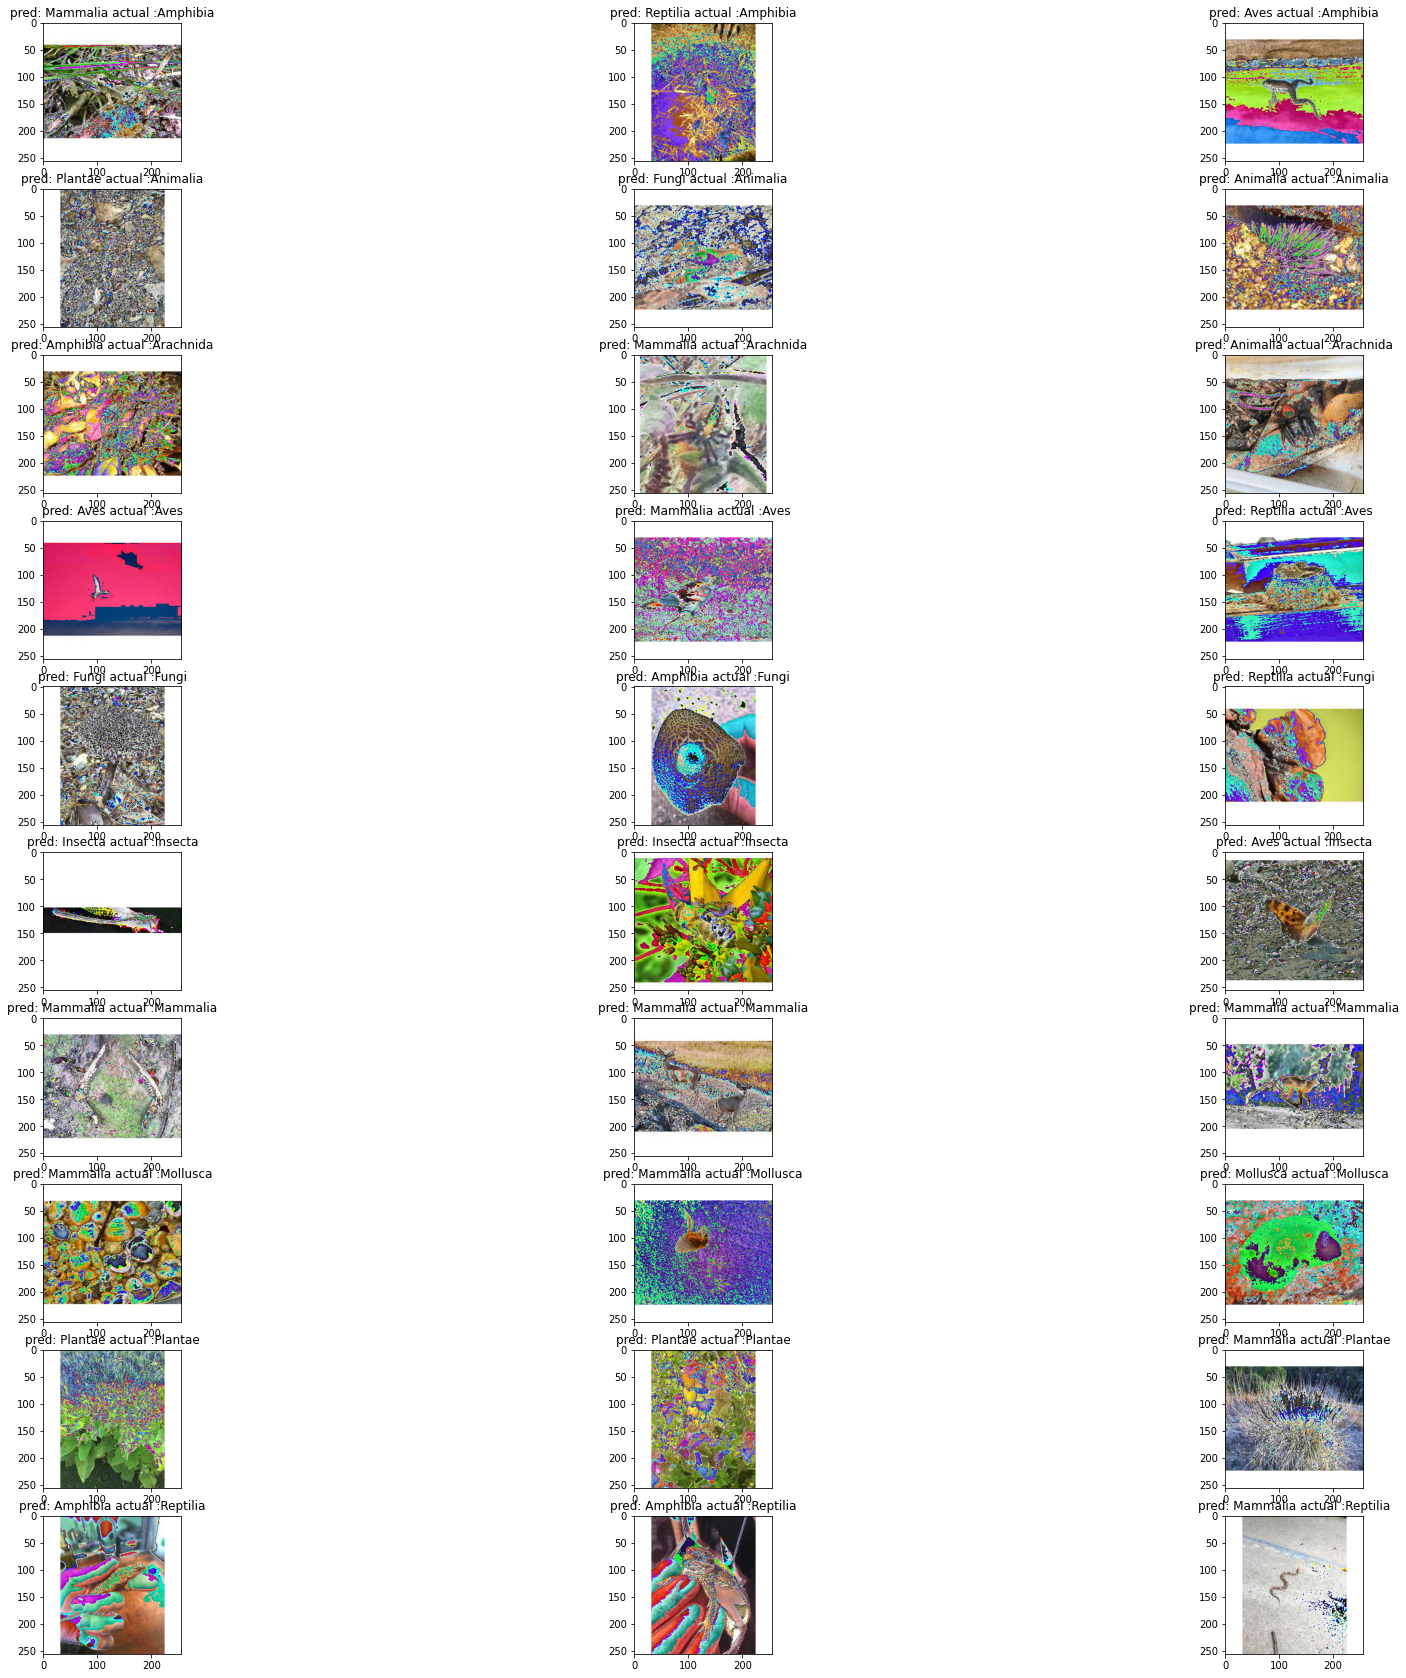

In [ ]:

rows = 10
cols = 3
plt.figure(figsize=(30, 30))
i = 1
for class_index,l in enumerate(sample_images_prediction):
    for t in l:
        plt.subplot(rows,cols,i)
        plt.imshow((t[0]*255).astype(np.uint8))
        plt.title("pred: "+classes[t[1]]+" actual :"+classes[class_index])
        i += 1
plt.show()



In [ ]:
print(conf_matrix)
print(class_accuracy)

[[ 46  11  15  23  15  18  38   7  12  15]
 [ 22  38   9  19  30   7  33  16  12  14]
 [ 17  15  83  20   8  15  16   5  13   8]
 [  2   3  15 109   1  10  43   4   7   6]
 [  8   9   8  10  82   5  29  17  26   6]
 [ 10   8  37  26   7  66  11  11  15   9]
 [  8   7   3  36   8   5 109   3   8  13]
 [ 24  19  17  11  29   6  33  45   5  11]
 [  6   4  18   8   9  12  29   4 105   5]
 [ 32  15  10  17  15  10  41   5  16  39]]
[23.  19.  41.5 54.5 41.  33.  54.5 22.5 52.5 19.5]


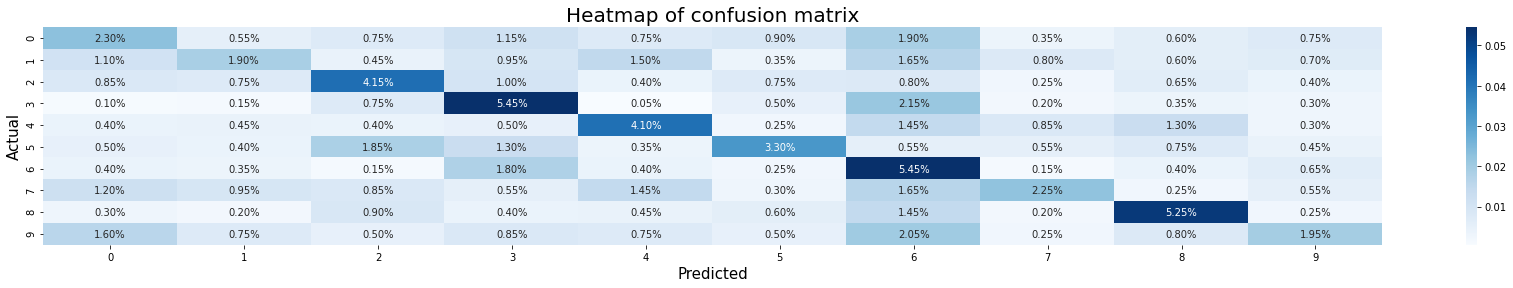

In [ ]:
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.title('Heatmap of confusion matrix', fontsize = 20)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15) 
plt.rcParams["figure.figsize"] = (30,4)
plt.show()

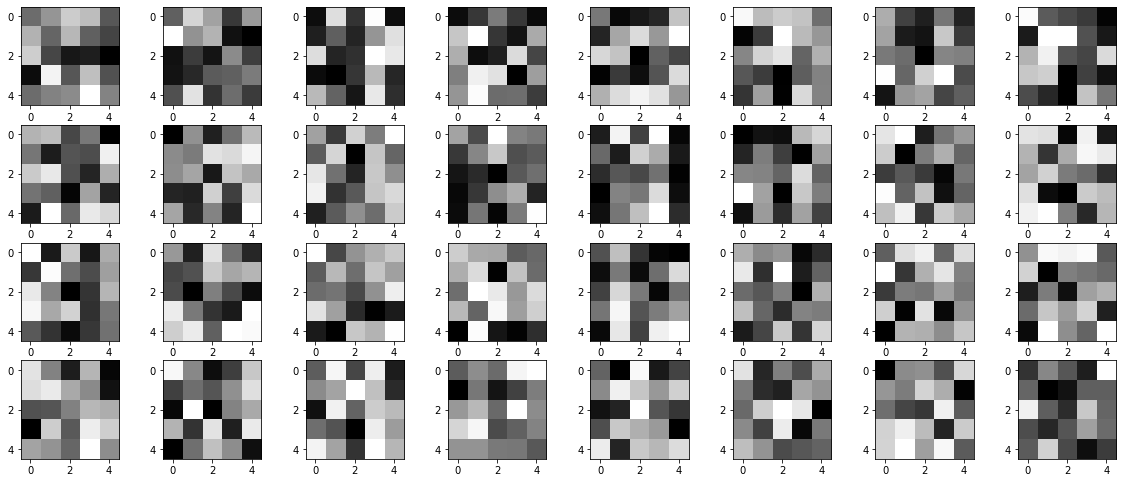

In [ ]:
# get all the model children as list
model_children = list(model.children())

first_layer_weights = model_children[0].weight
first_conv_layer = model_children[0]

plt.figure(figsize=(20, 17))
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].cpu().detach(), cmap='gray')
plt.show()

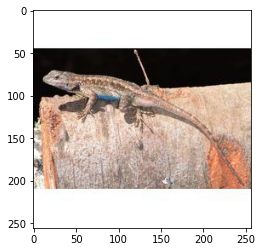

In [ ]:
some_image = Image.open(os.path.join(new_test_folder_path,'Reptilia','5a2cf2ce09e62df7260f595e6a63bda3.jpg'))
plt.imshow(some_image)
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std = std)
])

img = transform(some_image)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


torch.Size([32, 254, 254])


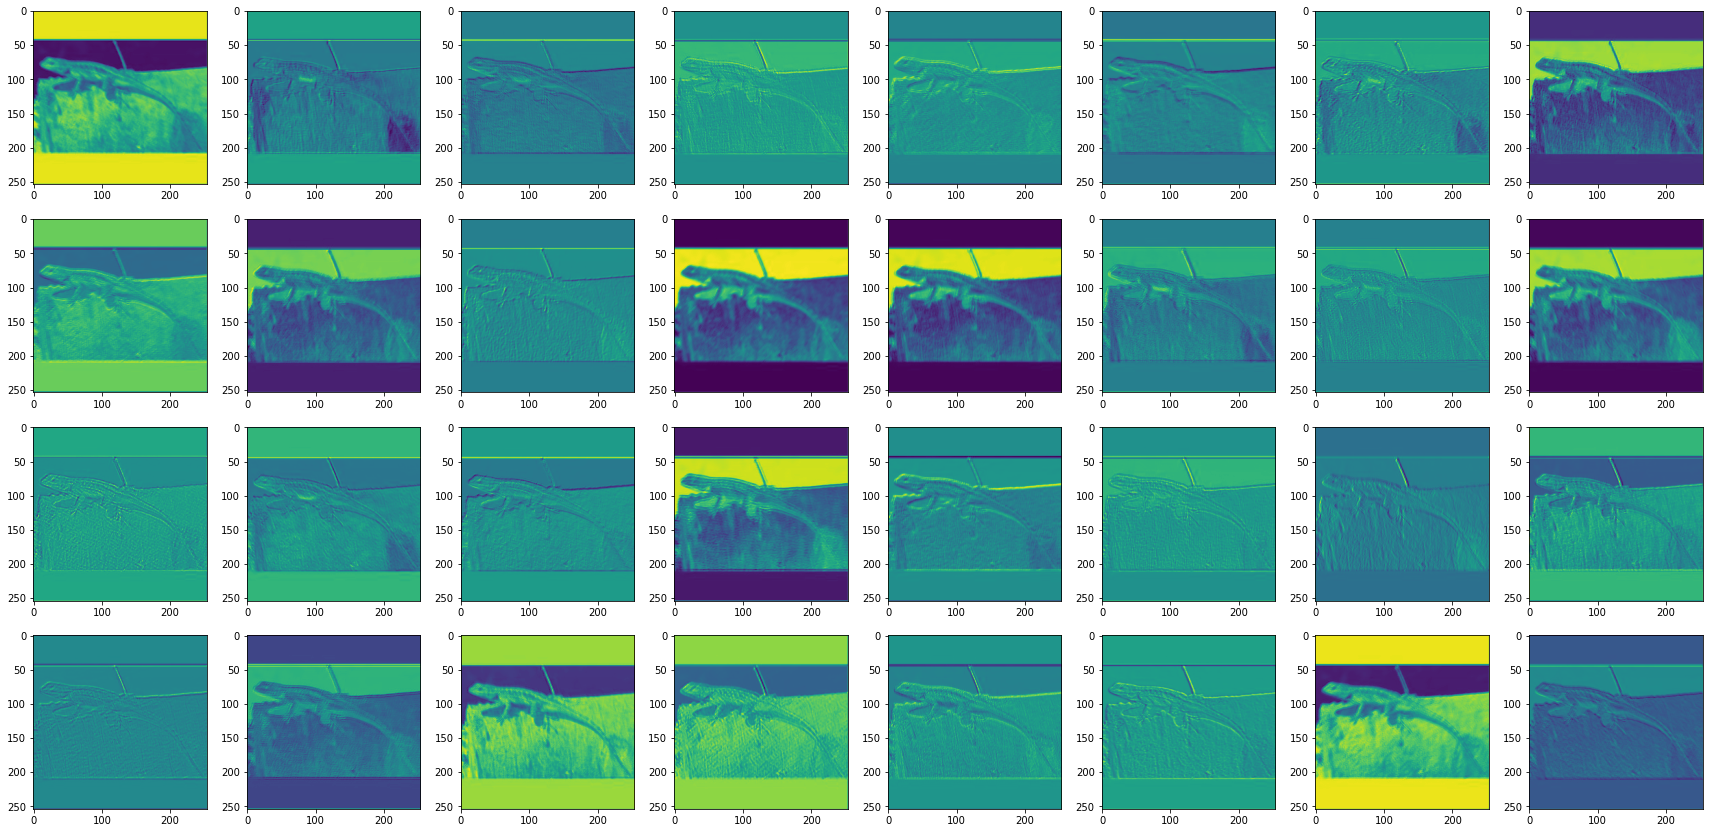

Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))

In [ ]:
result = first_conv_layer.cpu()(img)

plt.figure(figsize=(30, 30))
layer_viz = result[0, :, :, :]
layer_viz = layer_viz.data
print(layer_viz.size())
for i, filter in enumerate(layer_viz):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter)
plt.show()

first_conv_layer.cuda()

#Guided Back Propagation